In [1]:
#optional if initialization doesnt work
!pip install geopandas contextily folium plotly
!pip install --upgrade altair

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 4.2.2
    Uninstalling altair-4.2.2:
      Successfully uninstalled altair-4.2.2


In [2]:
from google.colab import drive
import pandas as pd
import geopandas as gpd
import zipfile
import matplotlib.pyplot as plt
import json
import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import altair as alt
import folium
from shapely.ops import nearest_points
import plotly.express as px
from folium.plugins import FeatureGroupSubGroup
from folium.plugins import MarkerCluster
from matplotlib import colormaps
from matplotlib.colors import ListedColormap

# Data Cleaning

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# list files in Data.zip
zip_path = '/content/drive/My Drive/COMP 5960 Final Project/Data.zip'

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in z.filelist:
        print(f.filename)


EarthquakeEpicenters.geojson
HousingUnitInventory_CLEANED.geojson
LiquefactionPotential.geojson
Utah_Quaternary_Faults.geojson
UtahCountyBoundaries.geojson
UtahZipCodeAreas.geojson


In [5]:
# Function to read GeoJSON file from ZIP as a GeoDataFrame
def geojson_as_gdf(zip_file, geojson_file):
    with zipfile.ZipFile(zip_file, 'r') as z:
        with z.open(geojson_file) as f:
            gdf = gpd.read_file(f)  # Load directly as GeoDataFrame
            return gdf

## Earthquake Epicenter Dataset

In [6]:
# set max columns to display
pd.set_option('display.max_columns', None)

In [7]:
# read in epicenter data
epicenter_gdf = geojson_as_gdf(zip_path, 'EarthquakeEpicenters.geojson')

In [8]:
# rename year day and month columns
epicenter_gdf.rename(columns={'Year': 'Year', 'Mo': 'Month', 'Day': 'Day'}, inplace=True)

# convert year mo day hr min sec to datetime
epicenter_gdf['Date'] = pd.to_datetime(epicenter_gdf[['Year', 'Month', 'Day']])
epicenter_gdf.drop(columns=['Month', 'Day', 'Hr', 'Min_', 'Sec'], inplace=True)

# reorder columns
cols = epicenter_gdf.columns.tolist()
cols = cols[:1] + cols[-1:] + cols[1:-1]
Epicenter_df = epicenter_gdf[cols]



 According to Michigan Tech's Earthquake Magnitude Scale, earthquakes with a magnitude of 2.5 or less are usually not felt. We dropped earthquakes with a magnitude of 2.5 or less from our dataset.  https://www.mtu.edu/geo/community/seismology/learn/earthquake-measure/magnitude/

In [9]:
# drop entries with Mag less than 2.5
epicenter_df = epicenter_gdf[epicenter_gdf['Mag'] >= 2.5]

# sort by magnitude and drop duplicate dates keep first
epicenter_df.sort_values('Mag', ascending=False)
epicenter_df.drop_duplicates(subset='Date', keep='first')

# filter columns of interest
clean_epicenter_gdf = epicenter_df[['OBJECTID', 'Date', 'Year', 'Mag', 'Lat', 'Long', 'Depth', 'geometry']]

display(clean_epicenter_gdf.head())
print(clean_epicenter_gdf.shape)

,OBJECTID,Date,Year,Mag,Lat,Long,Depth,geometry
0,1,1850-02-22,1850,3.670,40.749,-111.849,0.0,POINT Z (-111.849 40.749 0)
1,2,1853-12-01,1853,4.049,39.706,-111.832,0.0,POINT Z (-111.832 39.706 0)
2,3,1859-08-28,1859,3.670,37.842,-112.827,0.0,POINT Z (-112.827 37.842 0)
3,4,1868-10-17,1868,3.284,39.361,-111.588,0.0,POINT Z (-111.588 39.361 0)
4,5,1872-03-27,1872,2.898,40.749,-111.849,0.0,POINT Z (-111.849 40.749 0)


(2758, 8)


## Fault Lines Dataset

In [10]:
faults_gdf = geojson_as_gdf(zip_path, 'Utah_Quaternary_Faults.geojson')

We chose to focus on fault zones which are made up of lots of little fault lines.

In [11]:
# drop entries with no fault zone
clean_faults_gdf = faults_gdf[faults_gdf['FaultZone'].notnull()]

# filter columns of interest
clean_faults_gdf = clean_faults_gdf.drop(columns=['OBJECTID', 'FaultNum','DipDirection', 'FaultName','SlipSense','SectionName', 'StrandName','MappingConstraint', 'MappedScale','Label','Summary','USGS_Link','Notes','Citation'])

# dissolve based on fault zone
clean_faults_gdf = clean_faults_gdf.dissolve(by='FaultZone')

display(clean_faults_gdf)

,geometry,SlipRate,FaultClass,FaultAge,Shape__Length
FaultZone,,,,,
Beaver Basin faults,"MULTILINESTRING ((-112.68252 38.50711, -112.67...",<0.2 mm/yr,class B,"<750,000",855.816135
East Bear Lake fault,"MULTILINESTRING ((-111.25631 42.00793, -111.25...",0.2 - 1 mm/yr,class A,"<130,000",319.845911
East Cache fault zone,"MULTILINESTRING ((-111.78007 41.76851, -111.78...",<0.2 mm/yr,class A,"<2,600,000",10200.804996
East Canyon fault,"MULTILINESTRING ((-111.57486 40.95528, -111.57...",<0.2 mm/yr,class B,"<2,600,000",27343.638538
Great Salt Lake fault zone,"MULTILINESTRING ((-112.59514 41.25723, -112.59...",0.2 - 1 mm/yr,class A,"<15,000",30639.042049
Hogsback fault,"MULTILINESTRING ((-110.71459 40.93253, -110.71...",0.2 - 1 mm/yr,class A,"<750,000",4715.334200
Hurricane fault zone,"MULTILINESTRING ((-113.28304 37.29695, -113.28...",<0.2 mm/yr,class A,"<15,000",42878.638768
Morgan fault,"MULTILINESTRING ((-111.68148 41.11155, -111.68...",<0.2 mm/yr,class A,"<2,600,000",5228.549883
Pilot Creek Valley fault zone,"MULTILINESTRING ((-114.02807 41.10757, -114.02...",<0.2 mm/yr,class A,"<2,600,000",1609.081112


 Here we are adding a column for the fault zone to the epicenter data so we can leverage them together in our visualizations more easily.

In [12]:
# Find nearest fault zone for each epicenter

# Ensure both GeoDataFrames are in the same CRS, e.g., WGS84 (EPSG:4326)
clean_epicenter_gdf = clean_epicenter_gdf.to_crs("EPSG:4326")
clean_faults_gdf = clean_faults_gdf.to_crs("EPSG:4326")

# Initialize an empty list to store the nearest FaultZone for each epicenter
nearest_zones = []

# Loop through each epicenter in clean_epicenter_gdf
for epicenter in clean_epicenter_gdf.geometry:
    min_distance = float('inf')
    nearest_zone_name = None

    # For each epicenter, find the nearest fault zone in 'zones'
    for _, zone in clean_faults_gdf.iterrows():
        # Find the nearest point on the fault zone geometry
        point_on_zone = nearest_points(epicenter, zone.geometry)[1]

        # Calculate the distance between the epicenter and this point on the fault zone
        distance = epicenter.distance(point_on_zone)

        # Check if this is the nearest zone so far
        if distance < min_distance:
            min_distance = distance
            nearest_zone_name = zone.name  # This will be the 'FaultZone' after dissolve

    # Append the nearest zone name to the list
    nearest_zones.append(nearest_zone_name)

# Add the 'FaultZone' column to the epicenter GeoDataFrame
clean_epicenter_gdf['FaultZone'] = nearest_zones

# Calculate and add energy columns (Energy log E = 5.24 + 1.44Mag)
clean_epicenter_gdf['Energy (J)'] = round(10 ** (5.24 + 1.44 * clean_epicenter_gdf['Mag']), 2)
clean_epicenter_gdf['Energy (Tons of TNT)'] = round(clean_epicenter_gdf['Energy (J)'] * 2.39006e-10, 2)

display(clean_epicenter_gdf)
print(clean_epicenter_gdf.shape)

,OBJECTID,Date,Year,Mag,Lat,Long,Depth,geometry,FaultZone,Energy (J),Energy (Tons of TNT)
0,1,1850-02-22,1850,3.670000,40.7490,-111.8490,0.0,POINT Z (-111.849 40.749 0),Wasatch fault zone,3.348112e+10,8.00
1,2,1853-12-01,1853,4.049000,39.7060,-111.8320,0.0,POINT Z (-111.832 39.706 0),Wasatch fault zone,1.176414e+11,28.12
2,3,1859-08-28,1859,3.670000,37.8420,-112.8270,0.0,POINT Z (-112.827 37.842 0),Hurricane fault zone,3.348112e+10,8.00
3,4,1868-10-17,1868,3.284000,39.3610,-111.5880,0.0,POINT Z (-111.588 39.361 0),Wasatch fault zone,9.310221e+09,2.23
4,5,1872-03-27,1872,2.898000,40.7490,-111.8490,0.0,POINT Z (-111.849 40.749 0),Wasatch fault zone,2.588928e+09,0.62
...,...,...,...,...,...,...,...,...,...,...,...
31811,31812,2016-12-13,2016,2.849944,38.2412,-112.3110,0.9,POINT Z (-112.311 38.2412 0.9),Beaver Basin faults,2.207595e+09,0.53
31819,31820,2016-12-17,2016,2.790322,41.6842,-111.6910,4.6,POINT Z (-111.691 41.6842 4.6),East Cache fault zone,1.811606e+09,0.43
31862,31863,2016-12-23,2016,2.801968,41.4203,-112.7425,2.1,POINT Z (-112.7425 41.4203 2.1),Great Salt Lake fault zone,1.882929e+09,0.45
31896,31897,2016-12-28,2016,2.788349,42.2260,-111.3998,-0.1,POINT Z (-111.3998 42.226 -0.1),East Bear Lake fault,1.799793e+09,0.43


(2758, 11)


## Housing Dataset

Salt Lake City is near the Wasatch fault zone where a major earthquake is expected in the next 50 years. We decided to focus the housing data on the Salt Lake area. Houses built before 1975 are more susceptible to damage, so we added a column for built before 1975.

In [13]:
# original file too large for github

'''# read in housing data
housing_gdf = geojson_as_gdf('Data.zip', 'HousingUnitInventory.geojson')

# Filter to only include Salt Lake County and add binary column in one step
clean_housing_gdf = housing_gdf[housing_gdf['COUNTY'] == 'Salt Lake'].copy()

# Add binary column for houses built before 1975
clean_housing_gdf['before_1975'] = (clean_housing_gdf['APX_BLT_YR'] < 1975).astype(int)

# Filter columns of interest
clean_housing_gdf = clean_housing_gdf[['OBJECTID', 'APX_BLT_YR', 'before_1975', 'geometry']]

# send to geojson
clean_housing_gdf.to_file("HousingUnitInventory_CLEANED.geojson", driver='GeoJSON')'''

'# read in housing data\nhousing_gdf = geojson_as_gdf(\'Data.zip\', \'HousingUnitInventory.geojson\')\n\n# Filter to only include Salt Lake County and add binary column in one step\nclean_housing_gdf = housing_gdf[housing_gdf[\'COUNTY\'] == \'Salt Lake\'].copy()\n\n# Add binary column for houses built before 1975\nclean_housing_gdf[\'before_1975\'] = (clean_housing_gdf[\'APX_BLT_YR\'] < 1975).astype(int)\n\n# Filter columns of interest\nclean_housing_gdf = clean_housing_gdf[[\'OBJECTID\', \'APX_BLT_YR\', \'before_1975\', \'geometry\']]\n\n# send to geojson\nclean_housing_gdf.to_file("HousingUnitInventory_CLEANED.geojson", driver=\'GeoJSON\')'

In [14]:
clean_housing_gdf = geojson_as_gdf(zip_path, 'HousingUnitInventory_CLEANED.geojson')

display(clean_housing_gdf.head())
print(clean_housing_gdf.shape)

,OBJECTID,APX_BLT_YR,before_1975,geometry
0,51295,1956.0,1,"POLYGON ((-111.967 40.68912, -111.96664 40.689..."
1,51296,1911.0,1,"POLYGON ((-111.85429 40.76894, -111.85429 40.7..."
2,51297,1909.0,1,"POLYGON ((-111.86832 40.74414, -111.86889 40.7..."
3,51298,1906.0,1,"POLYGON ((-111.86376 40.74482, -111.86376 40.7..."
4,51299,1963.0,1,"POLYGON ((-111.87667 40.77681, -111.87667 40.7..."


(250324, 4)


## Liquefaction Dataset

In [15]:
# read in liquefaction data
liquefaction_gdf = geojson_as_gdf(zip_path, 'LiquefactionPotential.geojson')

The liquefaction dataset will be part of the housing visualization, so we narrowed the data to just Salt Lake County.

In [16]:
# filter to ObjectIDs for Salt Lake County
# Had to manually identify ojects within salt lake county
clean_liquefaction_gdf = liquefaction_gdf[liquefaction_gdf['OBJECTID'].isin([96, 83, 99, 98, 103, 101, 102, 104, 106])]

display(clean_liquefaction_gdf.head())


,OBJECTID,PCODE,geometry
82,83,7,"POLYGON ((-112.00077 40.90969, -112.00059 40.9..."
95,96,1,"POLYGON ((-111.91614 40.82206, -111.91558 40.8..."
97,98,5,"POLYGON ((-111.89579 40.76416, -111.89483 40.7..."
98,99,9,"POLYGON ((-112.15904 40.72861, -112.16069 40.7..."
100,101,5,"POLYGON ((-112.12007 40.71755, -112.11892 40.7..."


## Zip Code Dataset

The zipcode data provides zipcodes, city, and county. This will help when we vizualize the data not on a map.

In [17]:
# read in zipcode data
zipcode = geojson_as_gdf(zip_path, 'UtahZipCodeAreas.geojson')
zipcode.head()

,OBJECTID,COUNTYNBR,NAME,SYMBOL,ZIP5,geometry
0,1,20,AXTELL,1,84621,"POLYGON ((-111.86721 39.10511, -111.86738 39.1..."
1,2,20,CENTERFIELD,2,84622,"POLYGON ((-111.72787 39.08957, -111.72836 39.0..."
2,3,20,GUNNISON,4,84634,"POLYGON ((-111.69808 39.23713, -111.6976 39.23..."
3,4,14,LEAMINGTON,5,84638,"POLYGON ((-112.20731 39.5078, -112.20748 39.50..."
4,5,14,GARRISON,4,84728,"POLYGON ((-113.26939 39.55251, -113.36655 39.3..."


In [18]:
zipcode.set_crs(epsg=4326, inplace=True)
clean_housing_gdf.set_crs(epsg=4326, inplace=True)  # Ensure same CRS as zip code data

,OBJECTID,APX_BLT_YR,before_1975,geometry
0,51295,1956.0,1,"POLYGON ((-111.967 40.68912, -111.96664 40.689..."
1,51296,1911.0,1,"POLYGON ((-111.85429 40.76894, -111.85429 40.7..."
2,51297,1909.0,1,"POLYGON ((-111.86832 40.74414, -111.86889 40.7..."
3,51298,1906.0,1,"POLYGON ((-111.86376 40.74482, -111.86376 40.7..."
4,51299,1963.0,1,"POLYGON ((-111.87667 40.77681, -111.87667 40.7..."
...,...,...,...,...
250319,452543,2005.0,0,"POLYGON ((-111.92339 40.48672, -111.92361 40.4..."
250320,452544,2005.0,0,"POLYGON ((-111.92358 40.48686, -111.92403 40.4..."
250321,452545,2005.0,0,"POLYGON ((-111.92369 40.48705, -111.92417 40.4..."
250322,452546,2014.0,0,"POLYGON ((-111.89029 40.6788, -111.88934 40.67..."


In [19]:
# Perform the spatial join - this will add zip code information to the housing data
# Here we use 'within' to check if the housing point falls within the zip code polygon
housing_with_zipcodes = gpd.sjoin(clean_housing_gdf, zipcode, how='left', predicate='within')

In [20]:
housing_with_zipcodes.drop(columns=['OBJECTID_left', 'index_right', 'OBJECTID_right'], inplace=True)


In [21]:
liquefaction_gdf.set_crs(epsg=4326, inplace=True)  # Ensure same CRS as zip code data

,OBJECTID,PCODE,geometry
0,1,1,"POLYGON ((-112.25081 42.00115, -112.24357 42.0..."
1,2,4,"POLYGON ((-112.23588 42.00121, -112.23183 42.0..."
2,3,7,"POLYGON ((-112.22236 42.00122, -112.22087 42.0..."
3,4,4,"POLYGON ((-112.21916 42.00124, -112.21747 42.0..."
4,5,1,"POLYGON ((-112.20433 42.00117, -112.20148 42.0..."
...,...,...,...
117,118,7,"POLYGON ((-111.86228 40.08973, -111.86148 40.0..."
118,119,5,"POLYGON ((-111.62458 40.08236, -111.62391 40.0..."
119,120,5,"POLYGON ((-111.66472 40.08334, -111.66442 40.0..."
120,121,1,"POLYGON ((-111.76013 40.04464, -111.76028 40.0..."


In [22]:
# Perform the spatial join - this will add zip code information to the housing data
# Here we use 'within' to check if the housing point falls within the zip code polygon
housing_with_zipcodes_pcode = gpd.sjoin(housing_with_zipcodes, liquefaction_gdf, how='left', predicate='within')

In [23]:
#drop objectID
housing_with_zipcodes_pcode.drop(columns=['OBJECTID'], inplace=True)

In [24]:
#filter to salt lake county
housing_with_zipcodes_pcode_filtered = housing_with_zipcodes_pcode[housing_with_zipcodes_pcode['COUNTYNBR'] == 18]
housing_with_zipcodes_pcode

,APX_BLT_YR,before_1975,geometry,COUNTYNBR,NAME,SYMBOL,ZIP5,index_right,PCODE
0,1956.0,1,"POLYGON ((-111.967 40.68912, -111.96664 40.689...",18,SALT LAKE CITY,2.0,84119,100.0,5.0
1,1911.0,1,"POLYGON ((-111.85429 40.76894, -111.85429 40.7...",18,SALT LAKE CITY,1.0,84102,95.0,1.0
2,1909.0,1,"POLYGON ((-111.86832 40.74414, -111.86889 40.7...",18,SALT LAKE CITY,3.0,84105,97.0,5.0
3,1906.0,1,"POLYGON ((-111.86376 40.74482, -111.86376 40.7...",18,SALT LAKE CITY,3.0,84105,95.0,1.0
4,1963.0,1,"POLYGON ((-111.87667 40.77681, -111.87667 40.7...",18,SALT LAKE CITY,4.0,84103,95.0,1.0
...,...,...,...,...,...,...,...,...,...
250319,2005.0,0,"POLYGON ((-111.92339 40.48672, -111.92361 40.4...",18,RIVERTON,5.0,84065,NaN,NaN
250320,2005.0,0,"POLYGON ((-111.92358 40.48686, -111.92403 40.4...",18,RIVERTON,5.0,84065,82.0,7.0
250321,2005.0,0,"POLYGON ((-111.92369 40.48705, -111.92417 40.4...",18,RIVERTON,5.0,84065,82.0,7.0
250322,2014.0,0,"POLYGON ((-111.89029 40.6788, -111.88934 40.67...",18,MURRAY,3.0,84107,103.0,5.0


Remove data that doesn't have a year built or is entered as 0.

In [25]:
# Drop rows where the year built is before 1800
housing_with_zipcodes_pcode = housing_with_zipcodes_pcode[housing_with_zipcodes_pcode['APX_BLT_YR'] >= 1800]



## Population Dataset

In [26]:
# Read the population GeoJSON file as gdf
with open("/content/drive/My Drive/COMP 5960 Final Project/CensusTracts2020.geojson", "r") as f:
    population_gdf = gpd.read_file(f)

# calculate area in square miles
# 1 square mile = 2,589,988.11 square meters
population_gdf['ALAND20_sq_miles'] = population_gdf['ALAND20'] / 2589988.11

# Calculate population per square mile
population_gdf['POP_per_sq_mile'] = population_gdf['POP100'] / population_gdf['ALAND20_sq_miles']

# Normalize for plotting
epsilon = 1
population_gdf['POP_per_sq_mile_log'] = np.log1p(population_gdf['POP_per_sq_mile'] + epsilon)

display(population_gdf.head())

,OBJECTID,STATEFP20,COUNTYFP20,TRACTCE20,GEOID20,NAME20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,POP100,HU100,geometry,ALAND20_sq_miles,POP_per_sq_mile,POP_per_sq_mile_log
0,1,49,049,000901,49049000901,9.01,Census Tract,G5020,S,1686016,0,+40.3051285,-111.6922978,5559,1958,"POLYGON ((-111.70145 40.31184, -111.69974 40.3...",0.650974,8539.506092,9.052693
1,2,49,049,002500,49049002500,25,Census Tract,G5020,S,1034541,0,+40.2296149,-111.6497278,4218,1653,"POLYGON ((-111.65691 40.22704, -111.6569 40.22...",0.399439,10559.823002,9.265001
2,3,49,049,003401,49049003401,34.01,Census Tract,G5020,S,9085765,23788,+40.0560227,-111.7122570,3896,1233,"POLYGON ((-111.74501 40.04366, -111.74456 40.0...",3.508033,1110.593734,7.014449
3,4,49,049,010210,49049010210,102.10,Census Tract,G5020,S,15810476,0,+40.4005884,-111.7306856,5868,1592,"POLYGON ((-111.7734 40.41554, -111.769 40.4155...",6.104459,961.264558,6.870328
4,5,49,049,000505,49049000505,5.05,Census Tract,G5020,S,3919712,0,+40.3700595,-111.7070846,3288,846,"POLYGON ((-111.72678 40.37546, -111.72663 40.3...",1.513409,2172.578216,7.684590


Use following dataframes for downstream analysis:

clean_epicenter_gdf  
clean_faults_gdf  
clean_housing_gdf  
clean_liquefaction_gdf  
housing_with_zipcodes_pcode   
population_gdf

# Data Exploration

## Analysis Question: Where are earthquakes happening in Utah?

 - Goal: To create a geographic visualization of earthquake epicenters and identify regions with high seismic density by showing earthquake epicenters and highlighting high magnitude (above 5.5) earthquakes from 1850-2016.



This is our first look at the epicenter data.

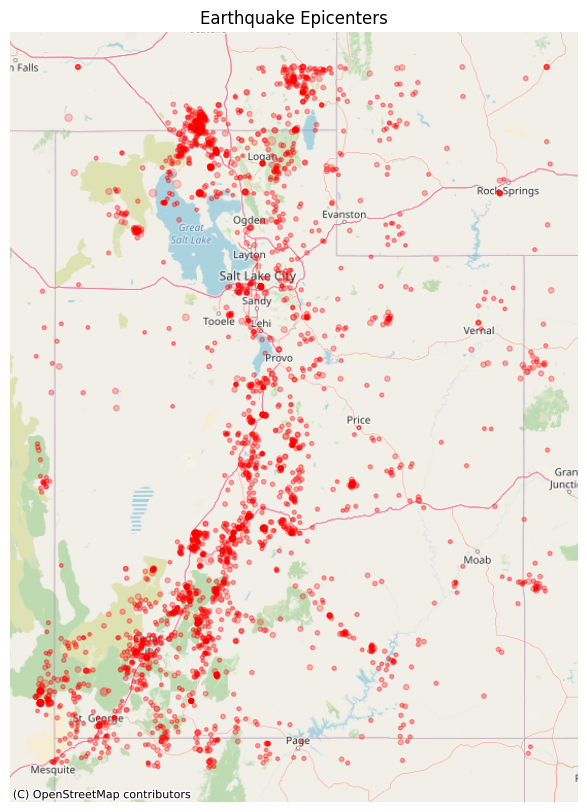

In [27]:
# Epicenter map

# Reproject GeoDataFrame to Web Mercator (EPSG:3857) for basemap compatibility
clean_epicenter_gdf = clean_epicenter_gdf.to_crs(epsg=3857)


# ENCODE MAGNITUDE AS area and make larger more transparent
clean_epicenter_gdf['markersize'] = clean_epicenter_gdf['Mag'] ** 2
clean_epicenter_gdf['opacity'] = 1 / clean_epicenter_gdf['Mag']

# Plot on map with basemap
fig, ax = plt.subplots(figsize=(10, 10))
clean_epicenter_gdf.plot(
    ax=ax,
    marker='o',
    color='red',
    markersize=clean_epicenter_gdf['markersize'],
    alpha=clean_epicenter_gdf['opacity'],
    label='Epicenters'
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Customize plot
plt.title('Earthquake Epicenters')
ax.axis('off')
plt.show()


Altair doesn’t support basemap interactivity so we are trying other options like folium and plotly. We ultimately decided not to go with this map and went with the simpler epicenter map similar to the one above but combine with a few other charts.

In [28]:

# Folium map

m = folium.Map(location=[40.6, -111.6], zoom_start=6, control_scale=True, zoom_control=True, scrollWheelZoom=True)
Faultzones = clean_epicenter_gdf['FaultZone'].unique().tolist()

marker_cluster = []
for i, l in enumerate(Faultzones):
    marker_cluster.append(MarkerCluster(name=l).add_to(m))
    filtered_gdf = clean_epicenter_gdf[clean_epicenter_gdf['FaultZone'] == l]
    for row in filtered_gdf.itertuples():
        location = row.Lat, row.Long
        popup = folium.Popup(
            f"Year: {row.Year}<br>"
            f"Fault Zone: {row.FaultZone}<br>"
            f"Magnitude: {row.Mag}<br>",
            max_width=450
            )
        marker = folium.Marker(location=location, popup=popup).add_to(marker_cluster[i])
    filtered_lines = clean_faults_gdf[clean_faults_gdf.index == l]
    for row in filtered_lines.itertuples():
        if row.geometry.geom_type == 'MultiLineString':
            for line in row.geometry.geoms:
                folium.PolyLine(locations=[(point[1], point[0]) for point in line.coords], color='blue', weight=1).add_to(marker_cluster[i])
        else:
            folium.PolyLine(locations=[(point[1], point[0]) for point in row.geometry.coords], color='blue', weight=1).add_to(marker_cluster[i])



# Add layer control to toggle layers
folium.LayerControl().add_to(m)
# display map
m
m.save("index.html")

In [29]:
# Plotly map
fig = px.scatter_mapbox(
    clean_epicenter_gdf,
    lat=clean_epicenter_gdf.Lat,
    lon=clean_epicenter_gdf.Long,
    color='Mag',
    hover_name='Year',
    hover_data=['FaultZone'],
    mapbox_style="open-street-map",
    title='Earthquake Epicenters and Fault Zones'
)

# Fault line plotting -> SLOW NEEDS DEBUGGING AT THE MOMENT
""" for idx, row in clean_faults_gdf.iterrows():
    if row.geometry.geom_type == 'MultiLineString':
        for line in row.geometry.geoms:
            fig.add_trace(px.line_mapbox(
                lat=[point[1] for point in line.coords],
                lon=[point[0] for point in line.coords],
                color_discrete_sequence=['blue']
            ).data[0])
    else:
        fig.add_trace(px.line_mapbox(
            lat=[point[1] for point in row.geometry.coords],
            lon=[point[0] for point in row.geometry.coords],
            color_discrete_sequence=['blue']
        ).data[0]) """


fig.update_layout(height = 800, mapbox_zoom=5, mapbox_center={"lat": clean_epicenter_gdf.Lat.mean(), "lon": clean_epicenter_gdf.Long.mean()})
fig.show()

## Analysis Question: How does earthquake frequency and magnitude vary over time?



One way we thought we could look at frequency over time was by creating a bubble chart with year on one axis, magnitude ranges on the other. After looking at this we realized there have not been that many earthquakes with a magnitude above 5.5 in Utah and we will have to tweak this map to help important data stand out.

In [30]:
clean_epicenter_gdf_mag = clean_epicenter_gdf

#MAY WANT TO BIN YEARS INTO DECADES

# create a column that labels 2.5-5.4, 5.5-6.0, 6.1-6.9, 7.0-7.9
clean_epicenter_gdf_mag['Mag_group'] = pd.cut(
    clean_epicenter_gdf['Mag'],
    bins=[2.5, 5.5, 6.1, 7.0, 8.0],
    labels=['2.5 to 5.4', '5.5 to 6.0', '6.1 to 6.9', '7.0 to 7.9']
)

#Count the number of Year Mag_group pairs and
count = clean_epicenter_gdf_mag.groupby(['Year', 'Mag_group'], observed=False).size().reset_index(name='counts')

#plot a bubble chart
source = count
alt.Chart(source).mark_circle().encode(
    x='Year:O',
    y='Mag_group:N',
    size='sum(counts):Q'
)


alt.Chart(...)

There are only 9 earthquakes greater than 5.5 in our dataset.

In [31]:
#show where Mag is > 5.5
clean_epicenter_gdf[clean_epicenter_gdf['Mag'] > 5.5]

,OBJECTID,Date,Year,Mag,Lat,Long,Depth,geometry,FaultZone,Energy (J),Energy (Tons of TNT),markersize,opacity,Mag_group
33,34,1884-11-10,1884,5.577000,42.3000,-111.4000,5.0,POINT Z (-12400991.265 5206024.468 5),East Bear Lake fault,1.865864e+13,4459.53,31.102929,0.179308,5.5 to 6.0
75,76,1901-11-14,1901,6.627542,38.5000,-112.4000,0.0,POINT Z (-12512310.757 4650301.842 0),Beaver Basin faults,6.076598e+14,145234.33,43.924313,0.150886,6.1 to 6.9
79,80,1902-11-17,1902,6.341000,37.3930,-113.5200,0.0,POINT Z (-12636988.587 4494028.415 0),Washington fault zone,2.349849e+14,56162.81,40.208281,0.157704,6.1 to 6.9
89,90,1909-10-06,1909,5.577000,41.8000,-112.7000,0.0,POINT Z (-12545706.604 5131067.342 0),Great Salt Lake fault zone,1.865864e+13,4459.53,31.102929,0.179308,5.5 to 6.0
203,204,1934-03-12,1934,6.591344,41.6580,-112.7950,8.5,POINT Z (-12556281.955 5109886.384 8.5),Great Salt Lake fault zone,5.389337e+14,128808.39,43.445816,0.151714,6.1 to 6.9
206,207,1934-03-12,1934,5.890994,41.5710,-112.7450,8.5,POINT Z (-12550715.981 5096932.386 8.5),Great Salt Lake fault zone,5.284834e+13,12631.07,34.703810,0.169751,5.5 to 6.0
373,374,1959-07-21,1959,5.550000,36.8000,-112.3700,0.0,POINT Z (-12508971.172 4411265.915 0),Sevier/Toroweap fault zone,1.706082e+13,4077.64,30.802500,0.180180,5.5 to 6.0
400,401,1962-08-30,1962,5.747449,41.9170,-111.7330,10.0,POINT Z (-12438060.656 5148554.55 10),East Cache fault zone,3.283421e+13,7847.57,33.033170,0.173990,5.5 to 6.0
1231,1232,1975-03-28,1975,6.019454,42.0628,-112.5247,8.7,POINT Z (-12526192.297 5170391.233 8.7),Wasatch fault zone,8.091215e+13,19338.49,36.233826,0.166128,5.5 to 6.0


Instead of focusing solely on earthquakes with a magnitude greater than 5.5, let's consider all earthquakes in Utah with a magnitude greater than 2.5, which is the minimum magnitude at which earthquakes can typically be felt. https://www.mtu.edu/geo/community/seismology/learn/earthquake-measure/magnitude/

We can also include our epicenter map in this visualization since it will be interesting to see all elements of the data

In [32]:
#print(alt.__version__)

### Visualization 1: Historical Utah Earthquakes (1850-2016) Interactive Chart

In [ ]:
import altair as alt

# Create a selection interval for the timeline
brush = alt.selection_interval(encodings=['x', 'y'])

# Define a dropdown selection for FaultZone
fault_zone_options = clean_epicenter_gdf['FaultZone'].unique().tolist()
fault_zone_dropdown = alt.selection_point(
    fields=['FaultZone'],  # The field to filter by
    bind=alt.binding_select(name='Select Fault Zone:', options=fault_zone_options),  # Create a dropdown binding
    clear=True  # Allow clearing the selection
)

# Timeline chart
# Interactive timeline chart with selection
timeline_chart = alt.Chart(clean_epicenter_gdf).mark_point(filled=True, opacity=0.75).encode(
    x=alt.X('Date:T', title='Date', scale=alt.Scale(domain=[clean_epicenter_gdf['Date'].min(), clean_epicenter_gdf['Date'].max()])),
    y=alt.Y('Mag:Q', title='Magnitude', scale=alt.Scale(domain=(2.5, 7))),
    size=alt.Size(
        'Energy (Tons of TNT):Q',
        scale=alt.Scale(range=[25, 500]),
        legend=None
    ),
    color=alt.condition(
        fault_zone_dropdown,  # Highlight points that match the selection
        alt.Color('Mag:Q', scale=alt.Scale(scheme='yelloworangered'), legend=alt.Legend(title='Magnitude', orient='left')),
        alt.value('lightgray')  # Gray for unselected points
    ),
    tooltip=[
        alt.Tooltip('Date:T', title='Date'),
        alt.Tooltip('Mag:Q', title='Magnitude'),
        alt.Tooltip('FaultZone:N', title='Fault Zone'),
        alt.Tooltip('Energy (Tons of TNT):Q', title='Energy (Tons of TNT)')
    ]
).add_params(
    fault_zone_dropdown
).add_params(
    brush
).properties(
    title='Earthquake Magnitudes',
    width=800,
    height=400
)

# Barchart
# Barchart filtered by selection
barchart = alt.Chart(clean_epicenter_gdf).mark_bar(color='#feb645', opacity=0.85).encode(
    x=alt.X('count():Q', title='Number of Earthquakes'),
    y=alt.Y('FaultZone:N', title='Fault Zone'),
    color=alt.condition(fault_zone_dropdown, alt.value('#feb645'), alt.value('lightgray'))
).add_params(
    fault_zone_dropdown
).transform_filter(
    brush
).properties(
    title='Earthquake Frequency by Fault Zone',
    width=800,
    height=150
)

# Map
# Read the Utah GeoJSON file
with open("/content/drive/My Drive/COMP 5960 Final Project/UtahZipCodeAreas.geojson", "r") as f:
    utah_geojson = json.load(f)

# Background map for Utah using mark_geoshape
background_map = alt.Chart(alt.Data(values=utah_geojson["features"])).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    title='Earthquake Epicenters',
    width=400,
    height=600
)

# Foreground earthquake data with circles
earthquake_map = alt.Chart(clean_epicenter_gdf).mark_circle(size=60, opacity=0.75).encode(
    longitude='Long:Q',
    latitude='Lat:Q',
    color=alt.Color('Mag:Q',
                    scale=alt.Scale(scheme='yelloworangered', domain=(2.5, 7)),
                    legend=None),
    size=alt.Size('Energy (Tons of TNT):Q',
                  scale=alt.Scale(range=[25, 500]),
                  legend=None),
    tooltip=[
        alt.Tooltip('Date:T', title='Date'),
        alt.Tooltip('Mag:Q', title='Magnitude'),
        alt.Tooltip('FaultZone:N', title='Fault Zone'),
        alt.Tooltip('Energy (Tons of TNT):Q', title='Energy (Tons of TNT)')
    ]
).transform_filter(
    brush
).transform_filter(
    fault_zone_dropdown
)

# Combine the background and earthquake layers
map_chart = alt.layer(
    background_map,
    earthquake_map
)

# Combine the histogram and timeline vertically
barchart_timeline = alt.vconcat(
    timeline_chart,
    barchart
).resolve_scale(
    color='independent'
)

# Combine the timeline, histogram, and map horizontally
combined_chart = alt.hconcat(
    barchart_timeline,
    map_chart
).resolve_scale(
    color='independent'
).properties(
    title={
        "text": "Historical Utah Earthquakes (1850-2016)",
        "fontSize": 18,
        "fontWeight": "bold",
        "anchor": "middle",
        "color": "black"
    }
)

combined_chart.show()


In [ ]:
# save as html
scatterplot_html = "/content/drive/My Drive/COMP 5960 Final Project/scatterplot.html"
combined_chart.save(scatterplot_html)

When talking about earthquake magnitude, it's helpful to keep in mind that magnitude and energy release are logarithmically related, with a one-unit increase in magnitude corresponding to about 32 times more energy release. The following visualization helps put this relationship into perspective highlighting the highest magnitude earthquakes in Utah while also showing what the energy output of the anticipated major earthquake might look like.

https://envisionutah.org/what-the-big-one-could-look-like

### Visualization 2: Earthquake Energy and Magnitude Correlation Custom Chart

In [ ]:
# filter for energy plot
energy_plot_df = clean_epicenter_gdf[['Year', 'Mag', 'FaultZone', 'Energy (Tons of TNT)']]
energy_plot_df = energy_plot_df.sort_values('Mag', ascending=False).reset_index(drop=True)
energy_plot_df = energy_plot_df[:4]

# add column Annotation set to blank
energy_plot_df['Annotation'] = ''

# add annotations
energy_plot_df.loc[0, 'Annotation'] = '1901 Richfield Earthquake'
energy_plot_df.loc[1, 'Annotation'] = '1934 Hansel Valley Earthquake'
energy_plot_df.loc[2, 'Annotation'] = '1902 Pine Valley Earthquake'
energy_plot_df.loc[3, 'Annotation'] = '1975 Pocatello Valley Earthquake'


# Create DataFrame with multiple entries
examples = pd.DataFrame([
    {
        'Year': 'Within 50 years',
        'Mag': 6.75,
        'FaultZone': 'Wasatch fault zone',
        'Energy (Tons of TNT)': round((10 ** (5.24 + 1.44 * 6.75)) * 2.39006e-10, 2),
        'Annotation': '2020-2070 Anticipated Wasatch Front Earthquake'
    },
    {
        'Year': 2020,  # No year for explosion
        'Mag': 5.7,
        'FaultZone': 'Wasatch fault zone',
        'Energy (Tons of TNT)': round((10 ** (5.24 + 1.44 * 5.7)) * 2.39006e-10, 2),
        'Annotation': '2020 Magna Earthquake'
    }
])

# append future earthquake to energy plot df
energy_plot_df = pd.concat([energy_plot_df, examples], ignore_index=True)

# Create dataframe for energy release line
magnitudes = np.arange(2, 6.9, 0.1)
energy_release_tnt = 10**(5.24 + 1.44 * magnitudes) * 2.39006e-10
energy_df = pd.DataFrame({
    'Magnitude': magnitudes,
    'Energy Release (Tons of TNT)': energy_release_tnt,
})

# Line chart for magnitude vs energy release
line_chart = alt.Chart(energy_df[20:]).mark_line(color='black', opacity=.8).encode(
    x=alt.X('Magnitude', title='Magnitude', axis=alt.Axis(grid=False)),
    y=alt.Y('Energy Release (Tons of TNT)', title='', axis=alt.Axis(grid=False))
)

# Point chart for individual earthquakes
point_chart = alt.Chart(energy_plot_df).mark_point(filled=True, opacity=1).encode(
    x=alt.X('Mag', title='Magnitude', scale=alt.Scale(domain=(4, 7.5)), axis=alt.Axis(grid=False)),
    y=alt.Y('Energy (Tons of TNT)', title='Energy Release (Tons of TNT)', axis=alt.Axis(grid=False)),
    size=alt.Size(
        'Energy (Tons of TNT)',
        scale=alt.Scale(range=[50, 800]),
        legend=None
    ),
    color=alt.Color(
        'Energy (Tons of TNT)',
        title='',  # Hide the title
        scale=alt.Scale(scheme='yelloworangered'),
        legend=None
    ),
    tooltip=[alt.Tooltip('Mag:Q', title='Magnitude'), 'Energy (Tons of TNT)']
)

# Text annotations next to each point
text_chart = alt.Chart(energy_plot_df).mark_text(
    align='right',
    dx=-15,
    dy=-5,
    fontWeight='bold'
    ).encode(
    x='Mag',
    y='Energy (Tons of TNT)',
    text=alt.Text('Annotation:N'),
    color=alt.condition(
        alt.datum.Annotation == '2020-2070 Anticipated Wasatch Front Earthquake',
        alt.value('#b00225'),
        alt.value('black')
    )
)

# Combine the layers
combined_energy = line_chart + point_chart + text_chart
combined_energy = combined_energy.properties(
    title={
        "text": "The Wasatch Range Is Predicted to Have an Earthquake With Magnitdue 6.75+",  # Main title
        "subtitle": ["This equates to an energy release of nearly 220,000 tons of TNT", " The 2020 Magna earthquake had an energy release around 6,700 tons of TNT"],  # Subtitle/paragraph
        "fontWeight": "bold",  # Main title style
        "fontSize": 15,  # Main title font size
        "anchor": "start",  # Align both title and subtitle to the left,
        "offset": 15,  # Add padding between title and subtitle
        "color": "black"
    },
    width=400,
    height=400
)

combined_energy

In [ ]:
energy_html = "/content/drive/My Drive/COMP 5960 Final Project/energy.html"
combined_energy.save(energy_html)

## Analysis Question: Which faults are associated with the highest magnitude earthquakes?

After looking at our data this question has become less important. We instead plan to look at fault lines and population.

In [ ]:
# Fault Zones Map

# Reproject GeoDataFrame to Web Mercator (EPSG:3857) for basemap compatibility
clean_faults_gdf = clean_faults_gdf.to_crs(epsg=3857)

# Plot on map with basemap
fig, ax = plt.subplots(figsize=(10, 10))
clean_faults_gdf.plot(ax=ax, color='blue', linewidth=1, label='Fault Zones')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Customize plot
# combine the two plots
fig, ax = plt.subplots(figsize=(10, 10))
clean_faults_gdf.plot(ax=ax, color='blue', linewidth=1, label='Fault Zones')
clean_epicenter_gdf.plot(ax=ax, marker='o', color='red', markersize=clean_epicenter_gdf['markersize'], alpha=clean_epicenter_gdf['opacity'], label='Epicenters')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Fault Zones with epicenter data')
plt.legend()
ax.axis('off')
plt.show()

This map combines the fault line data with a population dataset. We decided to go with this map because it highlights a different aspect of the data than our other visualizations.

### Visualization 3: Population Density and Fault Lines Map

In [ ]:
# Population and Fault lines Map
# Modify color map for better visibility
original_cmap = colormaps["Reds"]
colors = original_cmap(np.linspace(0.1, 1, 256))
modified_cmap = ListedColormap(colors)

# Plotting the log-transformed population density on a basemap using Contextily
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame
population_gdf.to_crs(epsg=3857).plot(
    column="POP_per_sq_mile_log",
    cmap=modified_cmap,  # Use the modified colormap
    #legend=False,
    ax=ax,
)
clean_faults_gdf.plot(ax=ax, color='black', linewidth=1, label='Fault Zones')

# Add a basemap from Contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("Fault Lines and Population Density", fontsize=16)
ax.set_axis_off()  # Remove axis for cleaner map display
plt.show()

## Analysis Questions: Housing risk

Where are houses and buildings located in relation to fault lines?

How many houses in Utah were built prior to 1975 and where are they located?

Our goal with the housing data is to show areas in the Salt Lake area that are more susceptible to damage during an earthquake.

This is the first plot we tried to see what the data would look like on a map. From here we can experiment with adding different layers like the fault lines or liquefaction data to highlight locations that are higher risk for damage.

In [ ]:
# Housing Unit Map

# Reproject GeoDataFrame to Web Mercator (EPSG:3857) for basemap compatibility
clean_housing_gdf = clean_housing_gdf.to_crs(epsg=3857)

# Plot on map with basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot areas built before 1975 in red
clean_housing_gdf[clean_housing_gdf['before_1975'] == 1].plot(
    ax=ax, color='red', label='Built Before 1975'
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Customize plot
plt.title('Housing Units by Construction Year')
ax.axis('off')
red_patch = mpatches.Patch(color='red')
plt.legend(handles=[red_patch])

plt.show()

This map uses a treemap which is another way to show the data without using a map.

In [ ]:

# Group by neighborhood and year
grouped_data = housing_with_zipcodes_pcode.groupby(['NAME', 'APX_BLT_YR','before_1975']).size().reset_index(name='count')

# Create the treemap
fig = px.treemap(grouped_data,
                 path=['NAME', 'APX_BLT_YR'],
                 values='count',
                 color='APX_BLT_YR',
                 color_continuous_scale='RdBu',


                 color_continuous_midpoint=1975,
                 title='Buildings by Neighborhood and Year Built')

fig.show()

In [ ]:
#changed before 1975 to 0 and after 1975 to 1 so the color scheme would work better in the following treemap
grouped_data['before_1975'] = grouped_data['before_1975'].replace({1: 0, 0: 1})

The following is the second iteration of the treemap. We made the little squares based off of a binary built prior to 1975 or after to more faithfully show the data along with improving the tool tip. We decided to use this visualization over the others looking at housing because it shows the data in a clear and concise way.

### Visualization 4: Housing Risk Treemap

In [ ]:
# Create the treemap

fig = px.treemap(grouped_data,
                 path=['NAME', 'APX_BLT_YR'],
                 values='count',
                 color='before_1975',
                 color_continuous_scale='RdBu',
                 title="Salt Lake County Housing Units by Earthquake Vulnerability<br><br><sup>Blocks represent the year houses were built; color indicates age (red: built before 1975, blue: 1975 or later); size reflects the number of houses built that year.</sup>")


fig.update_traces(hovertemplate='labels=%{label}<br>Number of houses built=%{value}<extra></extra>')
fig.update_layout(
    hoverlabel=dict(
        bgcolor="lightgrey"
    )
)
# Hide the legend
fig.update_coloraxes(showscale=False)

fig.show()

In [ ]:
# save as html
treemap_html = "/content/drive/My Drive/COMP 5960 Final Project/treemap.html"
fig.write_html(treemap_html)

In the peer feedback session, someone brought up how certain soils can change and become weaker during an earthquake. Having this data is a nice addition to the housing data to show areas more susceptible to damage.

Below is the first map we tried with the liquefaction data to make sure we could plot it.

### Visualization 5: Liquefaction Risk Map

In [ ]:

# Liquefaction Map

# Reproject GeoDataFrame to Web Mercator (EPSG:3857) for basemap compatibility
clean_liquefaction_gdf = clean_liquefaction_gdf.to_crs(epsg=3857)

# Define min and max values for color scaling
pcode_min = clean_liquefaction_gdf['PCODE'].min()
pcode_max = clean_liquefaction_gdf['PCODE'].max()

# Create a modified 'Reds' colormap to avoid white
reds_cmap = plt.colormaps['Reds']
new_reds_cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_reds', reds_cmap(np.linspace(0.2, 1, 256))
)

# Plot on map with color intensity based on 'PCODE'
fig, ax = plt.subplots(figsize=(10, 10))
clean_liquefaction_gdf.plot(
    ax=ax,
    column='PCODE',
    cmap=new_reds_cmap,
    legend=True,
    vmin=pcode_min,
    vmax=pcode_max,
    alpha=0.75,
    legend_kwds={'label': "Liquefaction Potential", 'orientation': "vertical"}
)

# Add basemap for context
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Customize plot
plt.title('Liquefaction Risk of Salt Lake County Housing Units')
ax.axis('off')
plt.show()

In the following map I use the dataset that combines the zip code, housing, and liquefaction datasets. This helps the housing and liquefaction maps be on the same scale. One downside is some of the data is lost because it is not associated with a house in the housing data. This could be ok because the places in the first map that are not shown in this map seem to correspond to places like the Jordan River and Kennecott Tailings Pond. Places that wouldn’t be at high risk for building damage during an earthquake.

In [ ]:

# Liquefaction Map

# Reproject GeoDataFrame to Web Mercator (EPSG:3857) for basemap compatibility
clean_liquefaction_gdf = housing_with_zipcodes_pcode.to_crs(epsg=3857)

# Define min and max values for color scaling
pcode_min = clean_liquefaction_gdf['PCODE'].min()
pcode_max = clean_liquefaction_gdf['PCODE'].max()

# Create a modified 'Reds' colormap to avoid white
reds_cmap = plt.colormaps['Reds']
new_reds_cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_reds', reds_cmap(np.linspace(0.2, 1, 256))
)

# Plot on map with color intensity based on 'PCODE'
fig, ax = plt.subplots(figsize=(10, 10))
clean_liquefaction_gdf.plot(
    ax=ax,
    column='PCODE',
    cmap=new_reds_cmap,
    legend=True,
    vmin=pcode_min,
    vmax=pcode_max,
    alpha=0.75,
    legend_kwds={'label': "Liquefaction Potential", 'orientation': "vertical"}
)

# Add basemap for context
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Customize plot
plt.title('Liquefaction Risk of Salt Lake County Housing Units')
ax.axis('off')
plt.show()

The following code was written to investigate housing risk with interactive folium maps, but the maps take a very long time to render.

Folium choropleth map

In [ ]:
'''from folium import Choropleth
import branca.colormap as cm
geo_data = clean_liquefaction_gdf

# Ensure 'p_code' column values are sorted and handle missing data
if 'PCODE' not in geo_data.columns:
    raise ValueError("The column 'PCODE' does not exist in the dataset.")
geo_data = geo_data.dropna(subset=['PCODE'])  # Drop rows with missing p_code values

# Normalize the p_code column
min_pcode = geo_data['PCODE'].min()
max_pcode = geo_data['PCODE'].max()

 # Create a colormap with shades of red
colormap = cm.LinearColormap(
    colors=["#ffcccc", "#ff9999", "#ff6666", "#ff3333", "#cc0000", "#990000"],
    vmin=geo_data['PCODE'].min(),
    vmax=geo_data['PCODE'].max(),
    caption="Liquefaction Risk (PCODE Intensity)"
    )

# Initialize the map
map_center = [40.6, -111.6]
m = folium.Map(location=map_center, zoom_start=11, tiles='cartodbpositron')

# Add polygons with colors based on p_code
for _, row in geo_data.iterrows():
    pcode_value = row['PCODE']
    color = colormap(pcode_value)
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, color=color: {
            'fillColor': color,
            'color': 'black',  # Boundary color
            'weight': 0.5,
            'fillOpacity': 0.7
        },
        #tooltip=f"PCODE: {pcode_value}, Year Built: {row['APX_BLT_YR']}, ZIP: {row['ZIP5']}"
    ).add_to(m)

# Add the colormap legend to the map
colormap.add_to(m)

m'''


The next map is an attempt to show a map that allows zooming in to each location to see the details of the pcode and year built. The dataset was too large to run the whole dataset at once, so we allow the user to select a subset of the data through a drop-down list of the cities. The map still loads slowly, and the setup isn't very smooth with the drop-down list so we may go with the liquefaction map above.

In [ ]:
'''import ipywidgets as widgets
from IPython.display import display

# Load your GeoDataFrame
geo_data = housing_with_zipcodes_pcode

# Global variable to store the selected city
selected_city = None

# Function to handle dropdown selection
def select_city(change):
    global selected_city
    selected_city = change['new']

# Create and display the dropdown widget
city_dropdown = widgets.Dropdown(
    options=geo_data['NAME'].unique(),
    description="Select City:",
    style={'description_width': 'initial'}
)
city_dropdown.observe(select_city, names='value')

# Display the dropdown
display(city_dropdown)'''


In [ ]:
'''import folium
from folium import Choropleth
import branca.colormap as cm

# Ensure 'p_code' column values are sorted and handle missing data
if 'PCODE' not in geo_data.columns:
    raise ValueError("The column 'PCODE' does not exist in the dataset.")
geo_data = geo_data.dropna(subset=['PCODE'])  # Drop rows with missing p_code values

# Ensure a city is selected
if not selected_city:
    print("Please select a city from the dropdown in the first cell.")
else:
    # Filter GeoDataFrame for the selected city
    filtered_data = geo_data[geo_data['NAME'] == selected_city]

    # Create the colormap (can reuse the one defined earlier)
    colormap = cm.LinearColormap(
        colors=["lightyellow", "yellow", "orange", "darkorange", "red", "darkred", "purple"],
        vmin=geo_data['PCODE'].min(),
        vmax=geo_data['PCODE'].max(),
        caption="Liquefaction Risk (PCODE Intensity)"
    )

    # Initialize the map
    map_center = [40.64, -111.95]  # Adjust as needed
    m = folium.Map(location=map_center, zoom_start=11, tiles='cartodbpositron')

    # Add polygons with colors based on PCODE
    for _, row in filtered_data.iterrows():
        pcode_value = row['PCODE']
        color = colormap(pcode_value)
        folium.GeoJson(
            row['geometry'],
            style_function=lambda x, color=color: {
                'fillColor': color,
                'color': color,  # Boundary color
                'weight': 0.5,
                'fillOpacity': 0.7
            },
            tooltip=f"PCODE: {pcode_value}, Year Built: {row['APX_BLT_YR']}, ZIP: {row['ZIP5']}"
        ).add_to(m)

    # Add the colormap legend to the map
    colormap.add_to(m)

    # Display the map
    display(m)'''


# Peer Feedback

We received the following feedback from Chetan Elenki, Kalpana Simhadri, and Nate Mason

* For the fault lines data show high risk and low risk areas with housing. Include legends of high and low risk
* Look into sediment of ground for risk of damage
* What would it look like if a 6.75 magnitude earthquake occurred in regard to infrastructure such as I-15
* Proportional symbol map for magnitude or a slider for magnitude


We plan to address this feedback by including the liquefaction dataset in our visualizations. We don't have the data to show what infrastructure damage could occur after a major earthquake, but the liquefaction dataset does show areas that could incur more damage. We also plan to include interactivity in our map including encoding magnitude by size and some kind of slider.

The feedback we received was helpful, especially the idea to look into data on sediment changes during earthquakes. The data we found based on that idea is interesting and adds another layer to our project.